## **MinION sequencing**

The purpose of DNA sequencing is to obtain the specific disposition of the consecutive nucleotides (A, T, G and C “letters”) of an organism. The entire nucleotide sequence of an organism is what is known as the genome. Among many achievements, DNA sequencing have allowed the identification of the characteristic genes of species and the identification of the genetic basis of many diseases. Although at the moment DNA sequencing is restricted to research centers and hospitals, some suggest that it will be a central tool in everyday life of all of us in the near future. Technological advances in the last 10 years have led to the development of new generation sequencing methods (also known as Next Generation Sequencing or NGS) that provide a massive amount of sequencing data, as millions of independent sequencing processes of the test sample or organism take place simultaneously, very quickly and at low cost. Sequencing of the entire genome is therefore attained by cloning the DNA, to obtain tons of short sequences (known as reads) that are variable need to be assembled like the pieces of a puzzle. As in a puzzle, the shorter the pieces that are provided by the technology, the larger the number of those pieces that are needed to complete the genome.

The most recent NGS methods (also known as Next NGS or third generation NGS) allow to obtain longer reads directly on real time from a single DNA molecule without the need to clone. This has many advantages, most prominently that the puzzle can be assembled with less pieces, and that the time and resources needed to complete the process (from sample to results) is dramatically reduced. A company called Oxford Nanopore Technologies (ONT) recently designed the smallest handheld sequencing device ever, called MinION. Because of this, MinION becomes portable, being limited just by the necessity to be plugged in to a computer to be able to work and analyze the resulting sequence. Sequencing is achieved by the use of biological nanopores that are inserted in a synthetic membrane (Figure 1). By their combination with other devices that are integrated on a circuit chip, the passage of each base of a single-stranded DNA sequence by the nanopore is translated into a signal that is characteristic for each base and its sequence of the environment.

![alt text](https://nanoporetech.com/sites/default/files/s3/sequencing-animated.gif)
Figure 1. Schematic representation of a nanopore inserted in a membrane with one DNA sequence passing through it, translating into a characteristic electric measurement. Figure taken from [ONT](https://nanoporetech.com/applications/dna-nanopore-sequencing) 

The characteristic electric signals, also called events, are recorded in a digital file with FAST5 format. For these to be understandable by us, the first step just after the sequencing is the translation of the electric signals generated into the nucleotide letters, a step known as basecalling. For this step NanoDJ uses a software called Albacore that runs from the command line with some important indications or arguments such as: the place (directory) where the FAST5 files are, the location where the output is to be delivered, the computer resources to be used (number of computing threads), and specific information of the reagents employed for preparing the sample. A typical line of arguments can be: 


In [ ]:
!read_fast5_basecaller.py -i data/sample/fast5 \
                         -r \
                         -t 48 \
                         -s data/sample/albacore_output/ \
                         -o fastq,fast5 \
                         -c r94_450bps_linear.cfg

After this first step, the user will obtain a new file in FASTQ format, which contains the nucleotide bases and is the standard type of data for the most analysis of the sequence. This file is a text file with information about the nucleotide sequence, but also with a quality score linked to each nucleotide in the sequence. Each of the sequences deposited in the FASTQ file are characterized by four lines:

- Line 1 begins with an '@' character and is followed by a sequence identifier and an optional description (such as a FASTA title line).
- Line 2 to represent the nucleotide sequence using one-letter codes.
- Line 3 starts with a '+' character and it is optionally followed by the same identifier as the sequence again (and any other description).
- Line 4 encodes the quality values declared by a characteristic symbol for the sequence in line 2, and must contain the same number of symbols as the letters in the sequence.

The following is an example:
```
@SEQ_ID
GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTT
+
! '' * ((((* +)) %%% ++) (%%%%). 1 * - + * '')) ** 55CCF >>>>>> CCCCCCC65
```

A FASTA file, which limits the information to the nucleotide sequence, can be derived from the FASTQ. Each of the sequences deposited in the FASTA file are characterized by two lines:
- Line 1 starts with a '>' character and it is followed by a sequence identifier and an optional description.
- Line 2 is the letter-encoded sequence.
```
>SEQ_ID
GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTT
```

Once the basecalling is done, an initial analysis to evaluate the quality of the reads resulting from the experiment is advised. For this, NanoDJ relies on the Python programming language and the Biopython module to evaluate the quality of basecalls, and the number, length and GC content of reads.

The following lines import the Biopython module and convert the FASTQ file in the FASTA file:


In [4]:
#Biopython module imports for loading and transforming sequence files
from Bio import SeqIO

SeqIO.convert("data/sample/reads.fastq", "fastq", "data/sample/reads.fasta", "fasta")

3720

With the FASTA file, the user can create a dataframe with the sequence information. The dataframe conversion allows to derive summary tables, plots and, if necessary, to impose steps of filtering in the data. The following defines a function that takes a FASTA/FASTQ file and builds a dataframe with all the information structured as columns.

In [5]:
from Bio.SeqUtils import GC

#Numpy and pandas to manage the data
import numpy as np
import pandas as pd

#Use reagular expressions for extract the read id
import re

#Function to build a pandas dataframe from a FASTA or FASTQ file
def read_sequence_file(filename, format):
    rows = []
    columns = ['id', 'sequence', 'read_length', 'gc_content']
    if(format == 'fastq'):
        columns.append('avg_quality')
    #Building each row with the read and its features
    for seq_record in SeqIO.parse(filename, format):
        if(format == 'fastq'):
            quality_score = np.mean(seq_record.letter_annotations["phred_quality"])
        read_id = seq_record.description
        if(format == 'fastq'):
            rows.append([read_id, seq_record.seq, len(seq_record.seq), GC(seq_record.seq), quality_score])
        else:
            rows.append([read_id, seq_record.seq, len(seq_record.seq), GC(seq_record.seq)])  
        
    df = pd.DataFrame(rows, columns=columns)
    return df



# ----- Place the path to your reads file here ----- #
seq_df = read_sequence_file('data/metagenomics/sample.fasta', 'fasta')

The following line of code will assess the following metrics from the dataframe and create a summary table:

- The number of sequences contained in the FASTA/FASTQ file, or equivalently the number of reads obtained by the experiment in case one experiment file is analyzed.
- The standard deviation of each parameter.
- Minimum and maximum values of each parameter.

In [6]:
seq_df.describe()

,read_length,gc_content
count,210.000000,210.000000
mean,7155.690476,44.071850
std,4102.249195,3.057562
min,218.000000,36.590437
25%,4308.500000,41.106855
50%,6752.500000,44.240571
75%,9655.500000,46.587005
max,29837.000000,54.424779


**Visualizations**

In the following steps, the user will build plots to visualize the results:

***Read length***

The following lines of code will create a plot with the read length distribution. The range of length distribution is represented in the x axis and the read count in y axis.

In [ ]:
#Using matplotlib to generate GC content histogram
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib

#Setting the plot size
matplotlib.rcParams['figure.figsize'] = (9, 8)

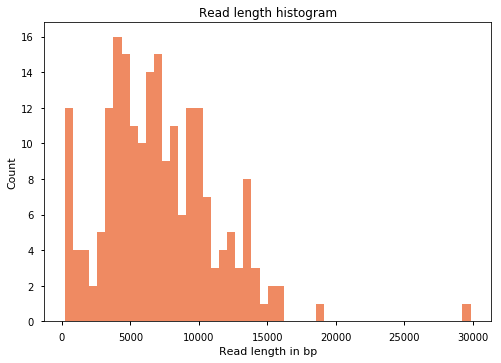

In [8]:
#Customize the plot using the pre-defined style called “ggplot” to emulate ggplot (popular R vizualization package) style 
plt.style.use('seaborn-notebook')

#On the plt.hist parameters set the number of bins and the bar color using labels as 'blue', 'red', 'yellow'... or using a RGB code.
plt.hist(seq_df['read_length'], bins=50, color='#ef8a62')
plt.title('Read length histogram')
plt.xlabel('Read length in bp')
plt.ylabel('Count')

plt.show()

***Guanine-Cytosine content (GC)***

GC content is the percentage of guanine or cytosine bases present in the DNA. The Guanine - Cytosine pair is bound in the double helix by three hydrogen bonds, which increases the stability of the DNA molecule. The GC content has an impact in the technology, as regions with higher or lower GC content are more difficult to sequence. Besides, the GC content is variable among the different organisms and regions of the genome. Due to the nature of the genetic code, it is practically impossible for an organism to have a genome with a GC content approaching 0% or 100%. Therefore, exploring the distribution of the GC content of the sequencing results can provide useful information, as it can help identifying possible artifacts in the data that must be discarded before moving forward in the analysis.

The distribution of GC content will be plotted with the following lines of code. The percentage of GC will be presented in the x axis and the number of reads in the y axis.

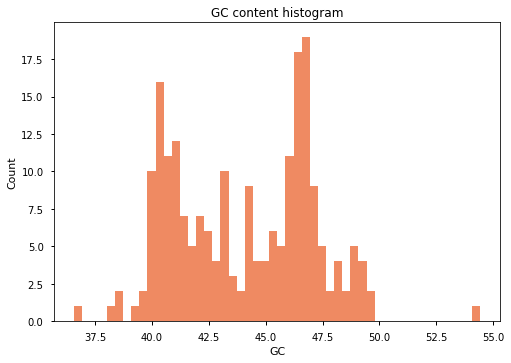

In [9]:
#Building histogram with the gc content column of the dataframe
plt.hist(seq_df['gc_content'], bins=50, color='#ef8a62')
plt.title('GC content histogram')
plt.xlabel('GC')
plt.ylabel('Count')
plt.show()

Once the quality control and filtering steps are performed, the user can proceed with the classification of the sequences obtained in the experiment. With this, the user will be able to deduce the organism(s) that have been sequenced on the experiment, even in the case there is a mixture of them. There is plenty of software that can do this efficiently. NanoDJ relies on BLAST as it helps reducing the computational resources needed by building the database with sequences from a limited set of species of interest. For this to work in NanoDJ, the user must follow the next steps:

1.- Create a database from the references file to be used by BLAST.  
2.- Run BLAST to classify the reads in the experiment.  
3.- Use Python for filtering and obtaining key information from the BLAST output.  
4.- Plot the results as a representation of the proportion of each species sequenced in the experiment.  


[BLAST](https://blast.ncbi.nlm.nih.gov) (stands for Basic Local Alignment Search Tool) is a classic and widely used tool for comparing DNA or protein sequences. BLAST needs a database where the reference sequences to be identified in an experiment are indexed for comparison (partial or complete genomes). In the following example, assume there are sequences from a complex environmental sample (typical from metagenomics experiments) that were obtained with MinION resulting in a number of reads from different DNAs from various unknown species. For simplicity, a database is built with seven genomes. These seven references were placed in one FASTA file. 

First, the user will create the database with the references file (all_metagenomics_references.fasta). The command makeblastdb will have the following arguments:

In [10]:
!makeblastdb -in data/metagenomics/reference/metagenomics_references_withnames.fasta -parse_seqids -dbtype nucl



Building a new DB, current time: 11/21/2018 18:20:33
New DB name:   /home/jovyan/notebooks/data/metagenomics/reference/metagenomics_references_withnames.fasta
New DB title:  data/metagenomics/reference/metagenomics_references_withnames.fasta
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 7 sequences in 0.00342703 seconds.


Once the database is created, the user is ready to query it with the obtained sequences of the FASTA file with unidentified sequences. The query command has the following arguments:

In [12]:
import os
if not os.path.exists('data/metagenomics/BLAST_Output'):
    os.makedirs('data/metagenomics/BLAST_Output')
!blastn -query data/metagenomics/sample.fasta -db data/metagenomics/reference/metagenomics_references_withnames.fasta -task blastn -dust no -outfmt "10 qseqid evalue sseqid" -evalue 11 -max_hsps 1 -max_target_seqs 1 -num_threads 1 > data/metagenomics/BLAST_Output/Sample.csv

The output is a table in csv format as it is easier to be processed by pandas package to analyze and plot the results. The results must be evaluated first in order to know which sequences aligned with any reference and which sequences did not align to any of the seven species represented in the database that was built. The data is grouped by subject so the user can count of sequences that aligned with each reference. Finally, because of the possibility that there may be artifacts in the sequencing results or because there may be a partial representation of species’ genomes in the built database, a proportion is obtained as the number of reads that are aligned to that reference divided by all reads aligning to any of the references. This will give the user a basic representation of species in the sequenced sample from which to draw conclusions of the experiment.

In [13]:
import numpy as np
import pandas as pd

df = pd.read_csv('data/metagenomics/BLAST_Output/Sample.csv', names=['id', 'score', 'subject'], header=None)

aligned_sequences = df.loc[df['score'] < 1, :]
unaligned_reads_count = len(df) - len(aligned_sequences)
print(len(aligned_sequences))

counts_df = aligned_sequences.groupby(['subject']).size().reset_index(name='counts')
counts_df = counts_df.append({'subject':'unaligned', 'counts':unaligned_reads_count}, ignore_index=True)
counts_df.columns = ['subject', 'counts']

#To transform the number of sequences into proportions
counts_df['counts'] = counts_df['counts'].map(lambda x: (x/(10000 - unaligned_reads_count)) * 100)
counts_df.columns = ['subject', 'proportion']

display(counts_df)

197


,subject,proportion
0,Alligator,0.270351
1,Bos,0.270351
2,Equus,0.290377
3,Gallus,0.290377
4,Oreochromis,0.330430
5,Ovis,0.270351
6,Ratus,0.250325
7,unaligned,0.130169


The following code takes the species proportions and builds a plot using the matplotlib module:

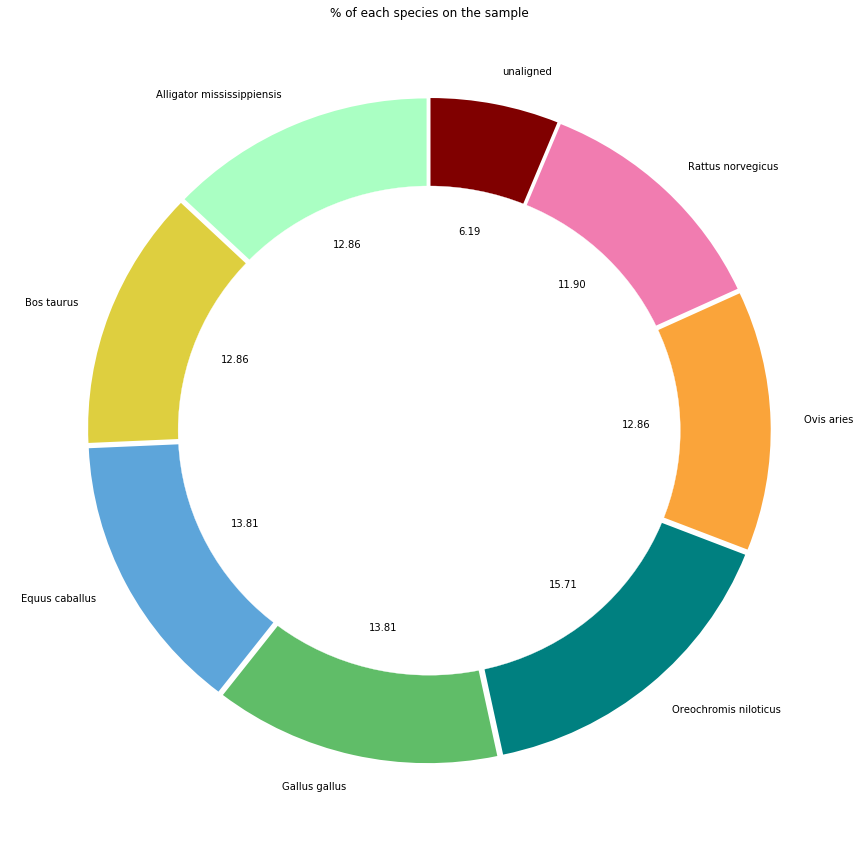

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,15)

colors = ['#aaffc3', '#DECF3F', '#5DA5DA', '#60BD68', '#008080', '#FAA43A', '#F17CB0', '#800000', '#B276B2', '#000080', '#F15854']#,'808080']
labels = ['Alligator mississippiensis', 'Bos taurus', 'Equus caballus', 'Gallus gallus', 'Oreochromis niloticus', 'Ovis aries', 'Rattus norvegicus', 'unaligned']
explode = (0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02)

plt.title('% of each species on the sample')
plt.pie(np.asarray(counts_df['proportion'].iloc[0:11]), autopct='%.2f', colors=colors, labels=labels, explode=explode, shadow=None, startangle=90)
centre_circle = plt.Circle((0,0),0.75,color='white', fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

### References

[1] Jain M., Olsen H. E., Paten B. and Akeson M. The Oxford Nanopore MinION: delivery of nanopore sequencing to the genomics community. Genome Biology. 2016, 17;239. DOI: https://doi.org/10.1186/s13059-016-1103-0

[2] Altschul S.F., Gish W., Miller W., Myers E.W., Lipman D.J. Basic local alignment search tool. J. Mol. Biol. Volume 215, Issue 3, 5 October 1990, Pages 403-410. DOI: https://doi.org/10.1016/S0022-2836(05)80360-2